In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.transforms import ToTensor


from torchinfo import summary

from tqdm import tqdm

from utils import config,device,show__random_img,calculate_mean_std_mnist

/home/muthu/miniconda3/envs/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Float16
torch.amp.autocast_mode.autocast("cuda",enabled=True,dtype=torch.float16)

# REPRODUCE
torch.backends.cudnn.deterministic=True
random.seed(hash('setting random seeds')% 2**32-1)
np.random.seed(hash('improves reproducibility')%2**32-1)
torch.manual_seed(hash("by removing stochasticity")%2**32-1)
torch.cuda.manual_seed_all(hash('so runs are repetable')%2**32-1)

In [3]:
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])


In [4]:
train_data = datasets.MNIST(config['data'].get('dir_path'), train=True, download=False, transform=train_transforms)
test_data = datasets.MNIST(config['data'].get('dir_path'), train=False, download=False, transform=test_transforms)

In [5]:
batch_size = 64

if torch.cuda.is_available():
    kwargs = {'batch_size': 64, 'shuffle': True, 'num_workers': 3, 'pin_memory': True}
else:
    kwargs = {'batch_size':32,'shuffle':True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [6]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()


def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)
    
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

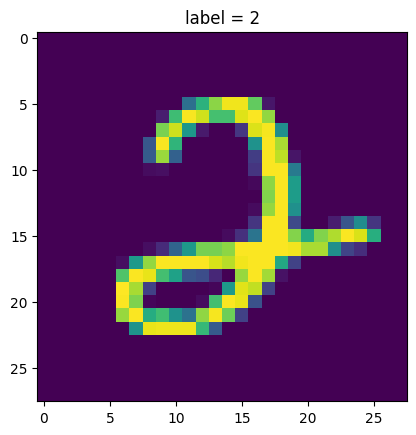

In [7]:
for i in random.choices(np.arange(0,20),k=1):
    plt.imshow(train_data.data[i])
    plt.title(f'label = {train_data.targets[i].numpy()}')
    plt.show()

### Model 1

In [8]:
from model import Net

In [9]:
model = Net().to(device)
# for name,weights in model.named_parameters():
#     print(f"{name}\t\t {weights.shape}")

optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# New Line
criterion =  F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Epoch 1


Train: Loss=0.1189 Batch_id=937 Accuracy=93.35: 100%|██████████| 938/938 [00:05<00:00, 158.54it/s]


Test set: Average loss: 0.0545, Accuracy: 9844/10000 (98.4400%)

Epoch 2


Train: Loss=0.1219 Batch_id=937 Accuracy=97.18: 100%|██████████| 938/938 [00:05<00:00, 176.17it/s]


Test set: Average loss: 0.0455, Accuracy: 9849/10000 (98.4900%)

Epoch 3


Train: Loss=0.0524 Batch_id=937 Accuracy=97.75: 100%|██████████| 938/938 [00:05<00:00, 173.87it/s]


Test set: Average loss: 0.0348, Accuracy: 9892/10000 (98.9200%)

Epoch 4


Train: Loss=0.0312 Batch_id=937 Accuracy=97.91: 100%|██████████| 938/938 [00:05<00:00, 176.62it/s]


Test set: Average loss: 0.0274, Accuracy: 9905/10000 (99.0500%)

Epoch 5


Train: Loss=0.0117 Batch_id=937 Accuracy=98.16: 100%|██████████| 938/938 [00:05<00:00, 165.60it/s]


Test set: Average loss: 0.0305, Accuracy: 9904/10000 (99.0400%)

Epoch 6


Train: Loss=0.0062 Batch_id=937 Accuracy=98.65: 100%|██████████| 938/938 [00:05<00:00, 169.32it/s]


Test set: Average loss: 0.0175, Accuracy: 9931/10000 (99.3100%)

Epoch 7


Train: Loss=0.0197 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:05<00:00, 165.88it/s]


Test set: Average loss: 0.0169, Accuracy: 9934/10000 (99.3400%)

Epoch 8


Train: Loss=0.0456 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:05<00:00, 166.98it/s]


Test set: Average loss: 0.0162, Accuracy: 9935/10000 (99.3500%)

Epoch 9


Train: Loss=0.0377 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:05<00:00, 173.82it/s]


Test set: Average loss: 0.0162, Accuracy: 9938/10000 (99.3800%)

Epoch 10


Train: Loss=0.1786 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:05<00:00, 167.83it/s]


Test set: Average loss: 0.0171, Accuracy: 9932/10000 (99.3200%)

Epoch 11


Train: Loss=0.0027 Batch_id=937 Accuracy=98.92: 100%|██████████| 938/938 [00:05<00:00, 163.02it/s]


Test set: Average loss: 0.0158, Accuracy: 9932/10000 (99.3200%)

Epoch 12


Train: Loss=0.0232 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [00:05<00:00, 164.35it/s]


Test set: Average loss: 0.0154, Accuracy: 9937/10000 (99.3700%)

Epoch 13


Train: Loss=0.1749 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:05<00:00, 164.42it/s]


Test set: Average loss: 0.0149, Accuracy: 9935/10000 (99.3500%)

Epoch 14


Train: Loss=0.0767 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:05<00:00, 164.78it/s]


Test set: Average loss: 0.0155, Accuracy: 9934/10000 (99.3400%)

Epoch 15


Train: Loss=0.0020 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:05<00:00, 175.48it/s]


Test set: Average loss: 0.0151, Accuracy: 9938/10000 (99.3800%)

Epoch 16


Train: Loss=0.0081 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:05<00:00, 181.49it/s]


Test set: Average loss: 0.0155, Accuracy: 9934/10000 (99.3400%)

Epoch 17


Train: Loss=0.0105 Batch_id=937 Accuracy=98.91: 100%|██████████| 938/938 [00:05<00:00, 183.97it/s]


Test set: Average loss: 0.0155, Accuracy: 9934/10000 (99.3400%)

Epoch 18


Train: Loss=0.0477 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:05<00:00, 187.49it/s]


Test set: Average loss: 0.0155, Accuracy: 9930/10000 (99.3000%)

Epoch 19


Train: Loss=0.0340 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:05<00:00, 186.63it/s]


Test set: Average loss: 0.0155, Accuracy: 9934/10000 (99.3400%)

Epoch 20


Train: Loss=0.0041 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [00:05<00:00, 185.76it/s]


Test set: Average loss: 0.0154, Accuracy: 9934/10000 (99.3400%)



In [10]:
summary(model=model,input_size=(1,1,28,28),device='cuda')

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 28, 28]           --
│    └─Conv2d: 2-1                       [1, 3, 28, 28]            27
│    └─BatchNorm2d: 2-2                  [1, 3, 28, 28]            6
│    └─ReLU: 2-3                         [1, 3, 28, 28]            --
│    └─Dropout2d: 2-4                    [1, 3, 28, 28]            --
│    └─Conv2d: 2-5                       [1, 8, 28, 28]            216
│    └─BatchNorm2d: 2-6                  [1, 8, 28, 28]            16
│    └─ReLU: 2-7                         [1, 8, 28, 28]            --
│    └─Dropout2d: 2-8                    [1, 8, 28, 28]            --
│    └─Conv2d: 2-9                       [1, 16, 28, 28]           1,152
│    └─BatchNorm2d: 2-10                 [1, 16, 28, 28]           32
│    └─ReLU: 2-11                        [1, 16, 28, 28]           --
│    └─Dropo

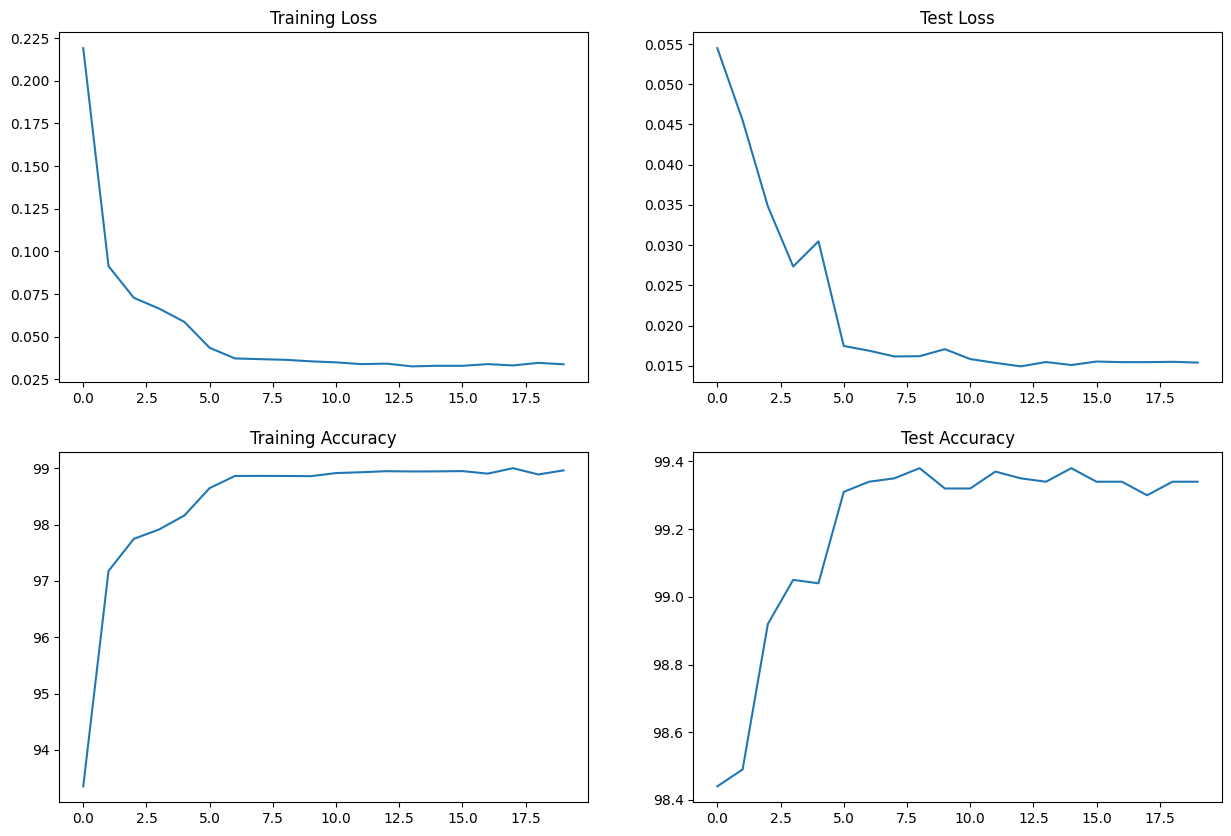

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
plt.show()

In [12]:
mnist_data = datasets.MNIST( root=config['data'].get('dir_path'), download=False, transform=transforms.ToTensor() ,)
mean,std= calculate_mean_std_mnist(mnist_data)

print(mean,std)

0.13065974414348602 0.3015038073062897
